# Malaria Diagnosis

Malaria parasites can be identified by examining under the microscope a drop of the patient’s blood, spread out as a “blood smear” on a microscope slide.

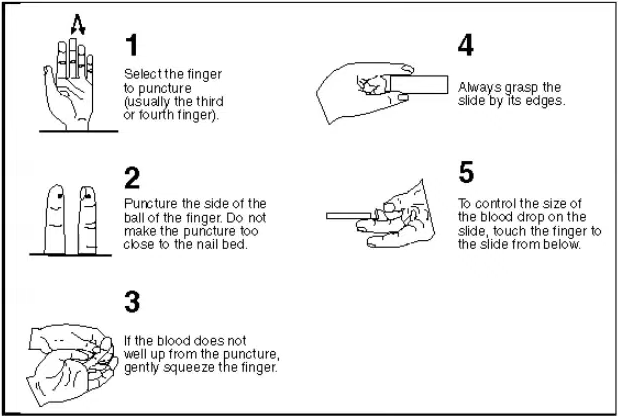

There are tow types of blood: This and Thick Smear. In this case, we are going to deal whith the thin smear.

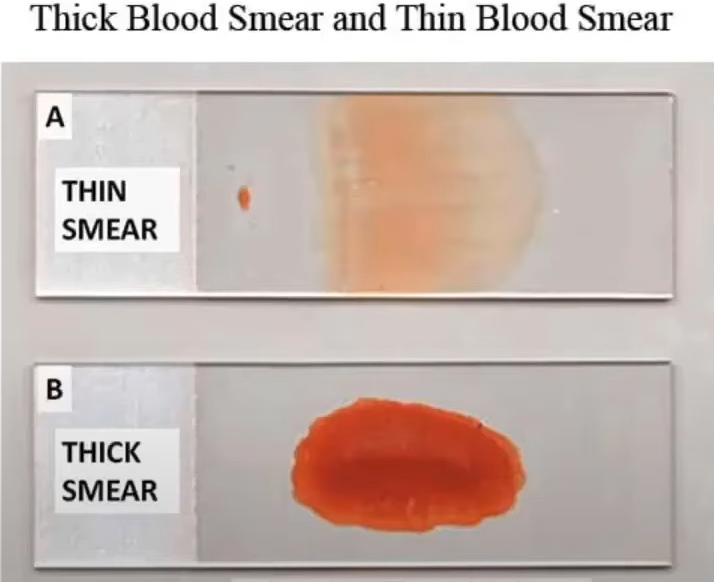

### Import libraries

In [1]:
import os
import wandb
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from wandb.keras import WandbCallback
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2, L1
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Input, Layer
from tensorflow.keras.metrics import BinaryAccuracy, FalseNegatives, FalsePositives, TrueNegatives, TruePositives, Precision, Recall, AUC

In [2]:
os.environ["WANDB_API_KEY"] = "0e6a1a5268419c907e2184a248b11821cea523c9"
os.environ["WANDB_MODE"] = "online"
wandb.login()
# wandb.init(project='malaria-detection', entity='alejandroserfer')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: alejandroserfer (aleserfer). Use `wandb login --relogin` to force relogin


True

### Import data and data preprocessing

In [3]:
dataset, dataset_info = tfds.load('malaria', as_supervised=True, with_info=True, shuffle_files=True, split=['train'])

In [4]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='C:\\Users\\aleja\\tensorflow_datasets\\malaria\\1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin 

In [5]:
TRAIN_SPLIT = 0.8
TEST_SPLIT = 0.1
VALIDATION_SPLIT = 0.1
DATASET_LEN = len(dataset[0])
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [6]:
train_len = int(TRAIN_SPLIT * DATASET_LEN)
test_len = int(TEST_SPLIT * DATASET_LEN)
validation_len = int(VALIDATION_SPLIT * DATASET_LEN)

train_dataset = dataset[0].take(train_len)
test_dataset = dataset[0].skip(train_len).take(test_len)
validation_dataset = dataset[0].skip(train_len + test_len).take(validation_len)

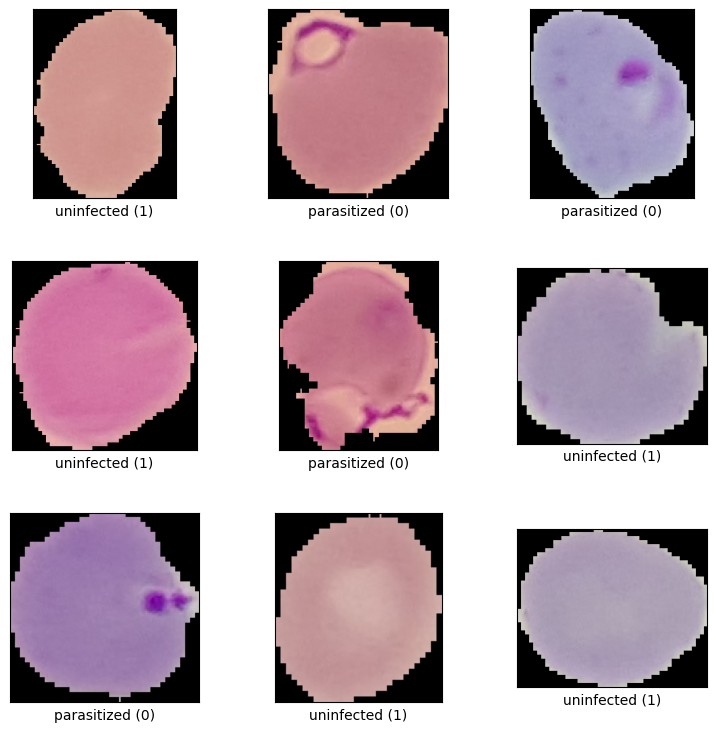

In [7]:
fig = tfds.show_examples(train_dataset, dataset_info)

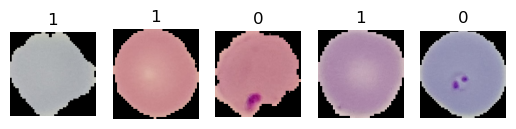

In [8]:
for i, (image, label) in enumerate(train_dataset.take(5)):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")
    

In [9]:
train_dataset = train_dataset.map(lambda x, y: (tf.image.resize(x, (IMG_HEIGHT, IMG_WIDTH)) / 255.0, y))
test_dataset = test_dataset.map(lambda x, y: (tf.image.resize(x, (IMG_HEIGHT, IMG_WIDTH)) / 255.0, y))
validation_dataset = validation_dataset.map(lambda x, y: (tf.image.resize(x, (IMG_HEIGHT, IMG_WIDTH)) / 255.0, y))

## Model building and evaluation

Model Configuration

In [12]:
configuration = {
    "LEARNING_RATE": 0.01,
    "EPOCHS": 10,
    "BATCH_SIZE": 32,
    "IMAGE_SIZE": 224,
    "DROPOUT": 0.1,
    "L2_REGULARIZATION": 0.01,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "POOL_SIZE": 2,
    "N_STRIDES": 1,
    "N_DENSE_1": 100,
    "N_DENSE_2": 16,
}

wandb.config = configuration

Hyperparameter Tuning

In [12]:
tuning_config = {
    "name": "malaria-tuning",
    "method": "random",
    "parameters": {

        "N_DENSE_1": {
            "values": [16, 32, 64, 100, 128]
        },

        "N_DENSE_2": {
            "values": [8, 16, 32, 48, 64]
        },

        "DROPOUT": {
            "values": [0.1, 0.2]
        },

        "LEARNING_RATE": {
            "values": [0.01, 0.001, 0.001, 0.002]
        },
}}

tuning_id = wandb.sweep(tuning_config, project="malaria-detection")

Create sweep with ID: g58ujwjy
Sweep URL: https://wandb.ai/aleserfer/malaria-detection/sweeps/g58ujwjy


In [13]:
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(configuration['BATCH_SIZE']).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(configuration['BATCH_SIZE']).prefetch(tf.data.experimental.AUTOTUNE)

In [13]:
class ConfusionCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_dataset):
        self.test_dataset = test_dataset
    
    def on_epoch_end(self, epoch, logs=None):
        y_pred = np.array([])
        y_true = np.array([])
        y_pred_wandb = np.array([])
        elements = []
        for x, y in self.test_dataset.as_numpy_iterator():
            y_true.append(y)
            elements.append(x[0,...])

        y_true = np.array(y_true).reshape(-1)
        elements = np.array(elements)
        predictions = model.predict(elements)
        predictions = predictions.reshape(-1)
        y_pred = np.array([1 if p > 0.5 else 0 for p in predictions])
        y_pred_wandb = np.array([[1, 0] if p > 0.5 else [0,1] for p in predictions])    

        cm = confusion_matrix(y_true, y_pred)
        print(cm)
        print(classification_report(y_true, y_pred))
        wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=y_pred,
                                                                    y_true=y_pred_wandb,                                                                    
                                                                    class_names=['Parasitized', 'Uninfected'])})        

### CNN Model based on LeNet

In [10]:
class ImageAugment(Layer):
    def __init__(self):
        super().__init__()
        self.k = tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.int32)

    def call(self, inputs):
        augmented_image = tf.image.rot90(inputs, self.k)
        augmented_image = tf.image.random_flip_left_right(augmented_image)
        return augmented_image

class ImageFeatureModel(Layer):
    def __init__(self, nfilters, kernel_size, strides, pool_size, l2_rate, dropout_rate, activation='relu', padding='same'):
        super(ImageFeatureModel, self).__init__()
        ImageAugmentLayer = ImageAugment()
        self.augment = ImageAugmentLayer
        self.conv1 = Conv2D(filters= nfilters, kernel_size = kernel_size, strides=strides, activation=activation, padding=padding, kernel_regularizer=L2(l2_rate))
        self.bn1 = BatchNormalization()
        self.maxpool1 = MaxPooling2D(pool_size=pool_size, strides=2*strides)
        self.dropout1 = Dropout(rate = dropout_rate)
        self.conv2 = Conv2D(filters = 2*nfilters, kernel_size = kernel_size, strides=strides, activation=activation, padding=padding, kernel_regularizer=L2(l2_rate))
        self.bn2 = BatchNormalization()
        self.maxpool2 = MaxPooling2D(pool_size=pool_size, strides=2*strides)

    def call(self, x):
        x = self.augment(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.maxpool2(x)
        return x


class CNNModel(Model):
    def __init__(self, config):
        super(CNNModel, self).__init__()
        ImageModel = ImageFeatureModel(nfilters=config['N_FILTERS'], kernel_size=config['KERNEL_SIZE'], 
                                              strides=config['N_STRIDES'], pool_size=config['POOL_SIZE'], 
                                              l2_rate=config['L2_REGULARIZATION'], dropout_rate=config['DROPOUT'])
        self.feature_model = ImageModel
        self.flatten = Flatten()
        self.dense1 = Dense(config['N_DENSE_1'], activation='relu', kernel_regularizer=L2(config['L2_REGULARIZATION']))
        self.bn1 = BatchNormalization()
        self.dropout1 = Dropout(rate = config['DROPOUT'])
        self.dense2 = Dense(config['N_DENSE_2'], activation='relu', kernel_regularizer=L2(config['L2_REGULARIZATION']))
        self.bn2 = BatchNormalization()
        self.dropout2 = Dropout(rate = config['DROPOUT'])
        self.dense3 = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.feature_model(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.dense2(x)
        x = self.bn2(x)
        x = self.dropout2(x)
        x = self.dense3(x)
        return x

In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=False, min_delta=0)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='malaria_cnn.h5', save_weights_only=True, 
                                                         monitor='val_loss', mode='min', save_best_only=True, save_freq='epoch')
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_binary_accuracy', factor=0.1, patience=3, verbose=1, mode='min')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs', histogram_freq=1)

In [17]:
metrics = [BinaryAccuracy(), FalseNegatives(), FalsePositives(), TrueNegatives(), TruePositives(), Precision(), Recall(), AUC()]

In [18]:
model = CNNModel(config = configuration)
model.compile(optimizer=Adam(learning_rate = configuration['LEARNING_RATE']), loss='binary_crossentropy', metrics=metrics)
model(tf.zeros([1, IMG_HEIGHT, IMG_WIDTH ,3]))
model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_feature_model (ImageF  multiple                 900       
 eatureModel)                                                    
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  3763300   
                                                                 
 batch_normalization_2 (Batc  multiple                 400       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 dense_1 (Dense)             multiple                  16

### Wandb Sweep for hyperparameter tuning

In [ ]:
def train():
    with wandb.init(project= 'malaria-detection', entity='alejandroserfer', config=configuration):
        config = wandb.config
        model = CNNModel(config = config)
        model.compile(optimizer=Adam(learning_rate = config.LEARNING_RATE), loss='binary_crossentropy', metrics=metrics)
        model(tf.zeros([1, IMG_HEIGHT, IMG_WIDTH ,3]))
        model.fit(train_dataset, validation_data=validation_dataset, epochs=config.EPOCHS, callbacks=[WandbCallback()])

count = 8
wandb.agent(tuning_id, function=train, count=count)

In [ ]:
wandb.finish()

Hyperparameter Tuning has been done using 10 epochs because of the computational power of my laptop.

Once we have finded the best hyperparameters, we can train the model with the best hyperparameters.

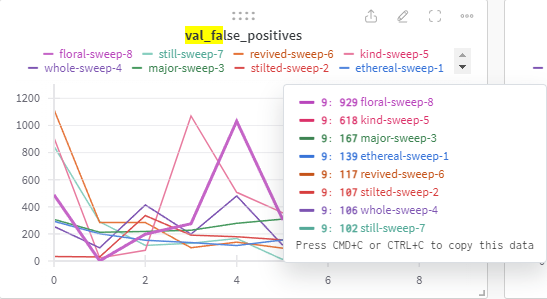

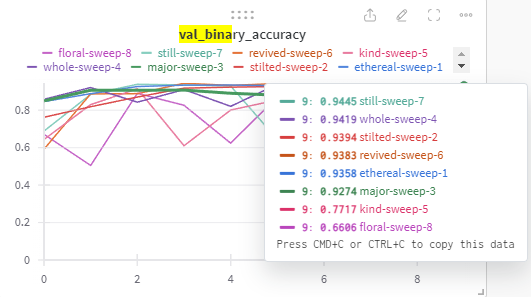

Best results has been obtained with run 'still-sweep-7', corresponding to the following configuration:

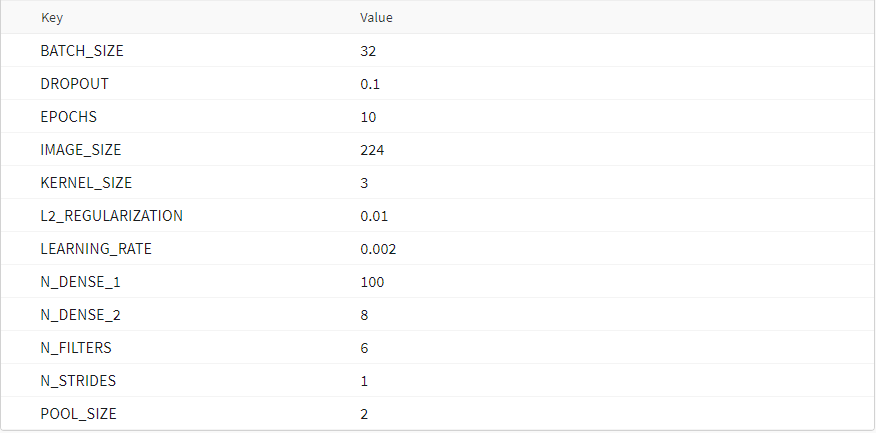

### Train the model with the best hyperparameters

In [14]:
configuration = {
    "LEARNING_RATE": 0.002,
    "EPOCHS": 20,
    "BATCH_SIZE": 32,
    "IMAGE_SIZE": 224,
    "DROPOUT": 0.1,
    "L2_REGULARIZATION": 0.01,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "POOL_SIZE": 2,
    "N_STRIDES": 1,
    "N_DENSE_1": 100,
    "N_DENSE_2": 8,
    # "PATIENCE": 5,
    # "MIN_DELTA": 0.001,
    # "EARLY_STOPPING": True,
}

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_false_negatives', patience=4, restore_best_weights=False, min_delta=0)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='malaria_cnn.h5', save_weights_only=True, 
                                                         monitor='val_false_negatives', mode='min', save_best_only=True, save_freq='epoch')
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_binary_accuracy', factor=0.1, patience=2, verbose=1, mode='min')
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs', histogram_freq=1)

In [16]:
metrics = [BinaryAccuracy(), FalseNegatives(), FalsePositives(), TrueNegatives(), TruePositives(), Precision(), Recall(), AUC()]

In [17]:
model = CNNModel(config = configuration)
model.compile(optimizer=Adam(learning_rate = configuration['LEARNING_RATE']), loss='binary_crossentropy', metrics=metrics)
model(tf.zeros([1, IMG_HEIGHT, IMG_WIDTH ,3]))
model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_feature_model (ImageF  multiple                 900       
 eatureModel)                                                    
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  3763300   
                                                                 
 batch_normalization_2 (Batc  multiple                 400       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 dense_1 (Dense)             multiple                  80

In [18]:
model = CNNModel(config = configuration)
model.compile(optimizer=Adam(learning_rate = configuration['LEARNING_RATE']), loss='binary_crossentropy', metrics=metrics)
model(tf.zeros([1, IMG_HEIGHT, IMG_WIDTH, 3]))
model.fit(train_dataset, epochs=configuration['EPOCHS'],
            validation_data=validation_dataset, 
            callbacks=[early_stopping, checkpoint_callback, 
                       lr_scheduler, 
                        # ConfusionCallback(test_dataset)
                        ])

Epoch 1/20
689/689 [==============================] - 69s 94ms/step - loss: 1.6679 - binary_accuracy: 0.6731 - false_negatives: 3319.0000 - false_positives: 3887.0000 - true_negatives: 7134.0000 - true_positives: 7706.0000 - precision: 0.6647 - recall: 0.6990 - auc: 0.7352 - val_loss: 1.9941 - val_binary_accuracy: 0.5245 - val_false_negatives: 7.0000 - val_false_positives: 1303.0000 - val_true_negatives: 93.0000 - val_true_positives: 1352.0000 - val_precision: 0.5092 - val_recall: 0.9948 - val_auc: 0.8006 - lr: 0.0020
Epoch 2/20
689/689 [==============================] - 64s 93ms/step - loss: 1.2103 - binary_accuracy: 0.8675 - false_negatives: 1214.0000 - false_positives: 1707.0000 - true_negatives: 9315.0000 - true_positives: 9810.0000 - precision: 0.8518 - recall: 0.8899 - auc: 0.9235 - val_loss: 0.8051 - val_binary_accuracy: 0.8457 - val_false_negatives: 62.0000 - val_false_positives: 363.0000 - val_true_negatives: 1027.0000 - val_true_positives: 1303.0000 - val_precision: 0.7821 - 

In [19]:
test_dataset = test_dataset.batch(1)
test_metrics = model.evaluate(test_dataset)

2755/2755 [==============================] - 39s 13ms/step - loss: 0.2555 - binary_accuracy: 0.9528 - false_negatives: 33.0000 - false_positives: 97.0000 - true_negatives: 1265.0000 - true_positives: 1360.0000 - precision: 0.9334 - recall: 0.9763 - auc: 0.9825


Predictions and results

In [20]:
labels = []
elements = []
for x, y in test_dataset.as_numpy_iterator():
    labels.append(y)
    elements.append(x[0,...])


In [21]:
label = np.array(labels).reshape(-1)
elements = np.array(elements)

In [22]:
predictions = model.predict(elements)
predictions = predictions.reshape(-1)

87/87 [==============================] - 3s 33ms/step


In [23]:
fpr, tpr, thresholds = roc_curve(label, predictions)

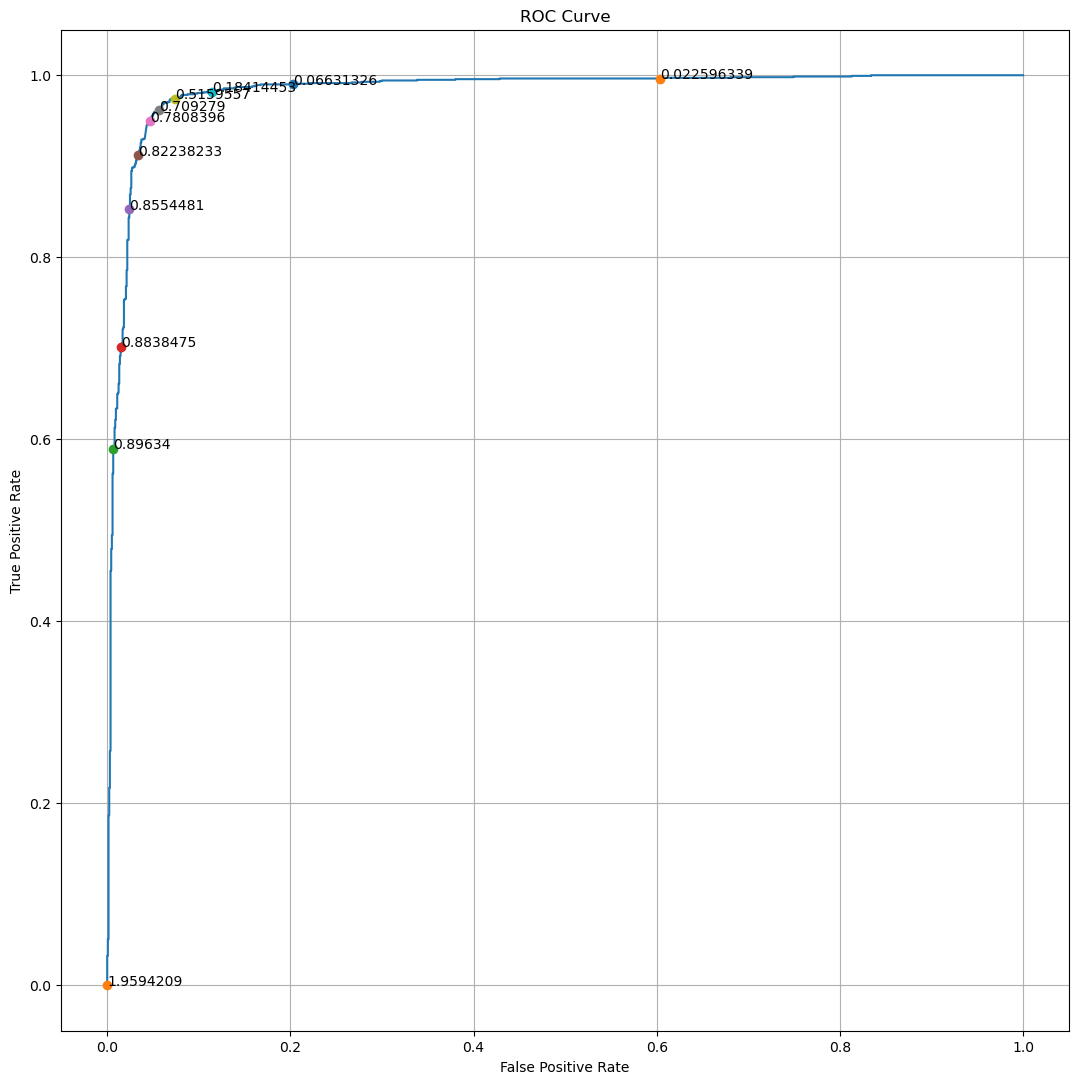

In [24]:
plt.figure(figsize=(13, 13))
plt.plot(fpr, tpr)
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

for i in range(0, len(thresholds), 20):
    plt.annotate(thresholds[i], (fpr[i], tpr[i]))
    plt.plot(fpr[i], tpr[i], 'o')


plt.show()

Text(0.5, 1.0, 'Confusion Matrix')

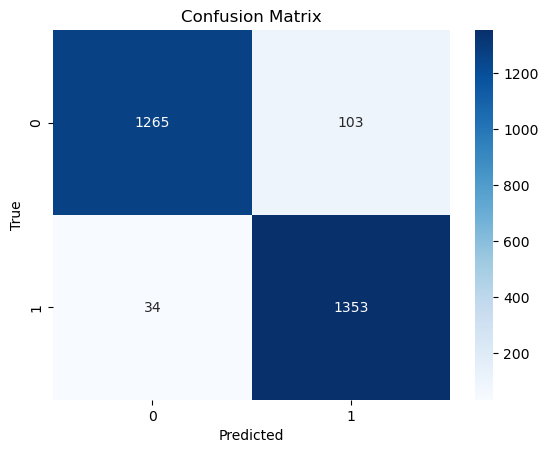

In [25]:
confusion_matrix(label, predictions > 0.5)
sns.heatmap(confusion_matrix(label, predictions > 0.5), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')